In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import PIL
import re
import time

from kaggle_datasets import KaggleDatasets
from IPython import display

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import ReLU, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except Exception as e:
    print("can't initialize tpu, using default, exception: " + str(e))
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

from PIL import Image
import shutil


Device: grpc://10.0.0.2:8470
Number of replicas: 8


## Step 1: Brief description of the problem and data

### 1.1 Problem

A generative adversarial network (GAN) is a generative model that defines an adversarial net framework and is composed of a couple of models (both models are CNNs in general), namely a generator and a discriminator, with the goal of generating new realistic images when given a set of training images. These two models act as adversaries of each other: the generator learns to generate new fake images that look like real images (starting with random noise) while the discriminator learns to determine whether a sample image is a real or a fake image. The two models are trained together in a zero-sum game, adversarially, and overtime, the generator gets better at generating images that are super close to real images and discriminator gets better at differentiating them. The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes.

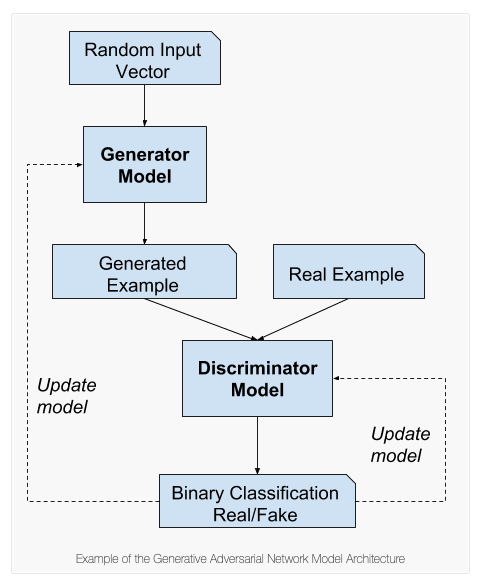

In this project, we will build and train a Deep Convolutional Generative Adversarial Network (DCGAN) with Keras to generate images of Monet-style.  

DCGAN is a type of GAN that uses convolutional neural networks (CNNs) as the generator and discriminator. CNNs are specifically designed for image recognition tasks and are well-suited for generating images using GANs. DCGAN includes several architectural changes compared to a regular GAN. It uses transposed convolutional layers for the generator instead of fully connected layers, and replaces pooling layers with strided convolutions. It also uses batch normalization to stabilize the training process and prevents the generator from collapsing.

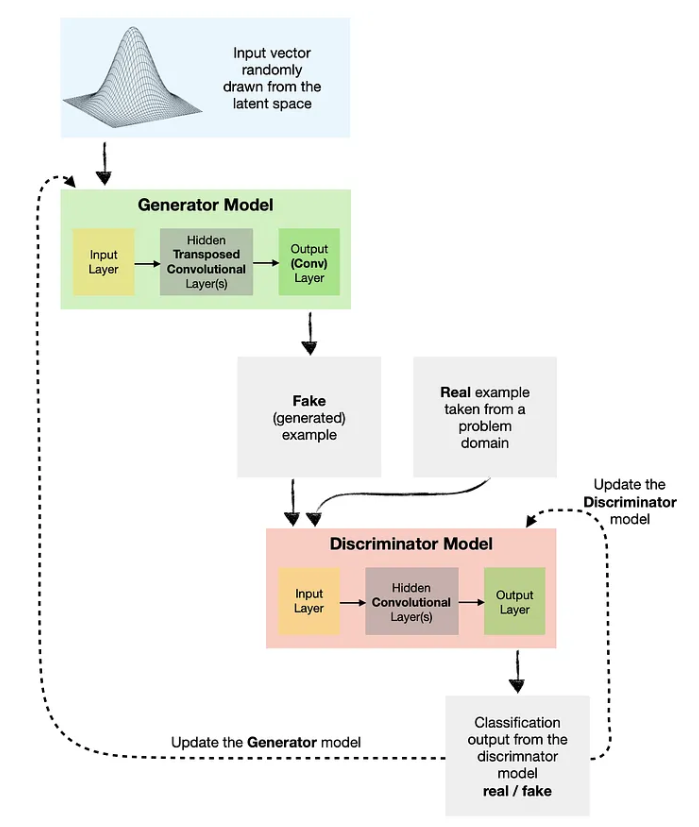

As we can see, the Discriminator model is just a Convolutional classification model. In contrast, the Generator model is more complex as it learns to convert latent inputs into an actual image with the help of Transposed and regular Convolutions. In summary, while both GAN and DCGAN are used for generating new data, DCGAN specifically uses convolutional neural networks as the generator and discriminator, and includes several architectural changes to improve the stability and quality of generated data.

There are 4 major steps in the training:  
1. Build the generator.    
2. Build the discriminator.    
3. Define Loss Functions & Optimizers.  
4. Define the training loop & Visualize Images.  

### 1.2 Data


In this project, I use a dataset from Kaggle, was downloaded from the link:  
https://www.kaggle.com/competitions/gan-getting-started/data
  
The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg   directories contain the same photos.  

The monet directories contain Monet paintings. We will use these images to train our model.

The photo directories contain photos. We will add Monet-style to these images and submit our generated jpeg images as a zip file.

Files   
monet_jpg - 300 Monet paintings sized 256x256 in JPEG format   
monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format   
photo_jpg - 7028 photos sized 256x256 in JPEG format   
photo_tfrec - 7028 photos sized 256x256 in TFRecord format   

Reference Sources:    
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook   
https://www.tensorflow.org/tutorials/generative/dcgan


## Step 2: Exploratory Data Analysis (EDA)

#### Load in the data

In [2]:
# load in the filenames of the TFRecords
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(PHOTO_FILENAMES))

n_monet_samples = np.sum([int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in MONET_FILENAMES])
print(f'Monet image files: {n_monet_samples}')

n_photo_samples = np.sum([int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in PHOTO_FILENAMES])
print(f'Photo image files: {n_photo_samples}')

Monet TFRecord Files: 5
Monet TFRecord Files: 20
Monet image files: 300
Photo image files: 7038


In [3]:
# return the image from the TFRecord
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image


In [4]:
# define the function to extract the image from the files
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [5]:
# load in the datasets
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(32)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(32)

In [6]:
# Create iterators
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

In [7]:
# view shape of the datasets
print(example_monet.shape)
print(example_photo.shape)

(32, 256, 256, 3)
(32, 256, 256, 3)


In [8]:
# define visualization function to view image
def visualize_images(example):
    plt.figure(figsize = (10, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(example[i] * 0.5 + 0.5)
        plt.axis("off")

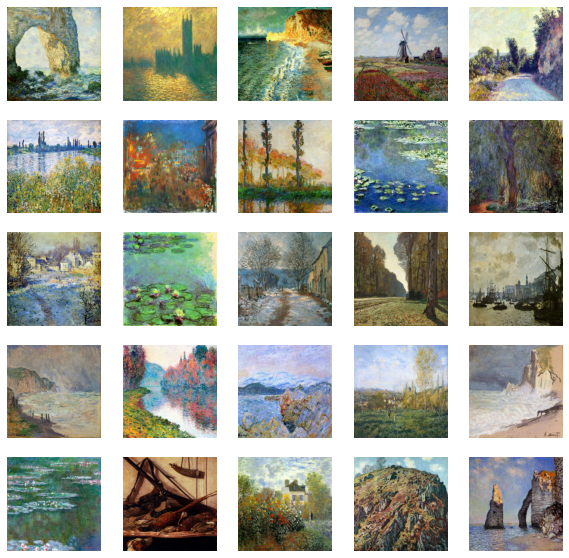

In [9]:
# Visualize some first images from the monet dataset
visualize_images(example_monet)

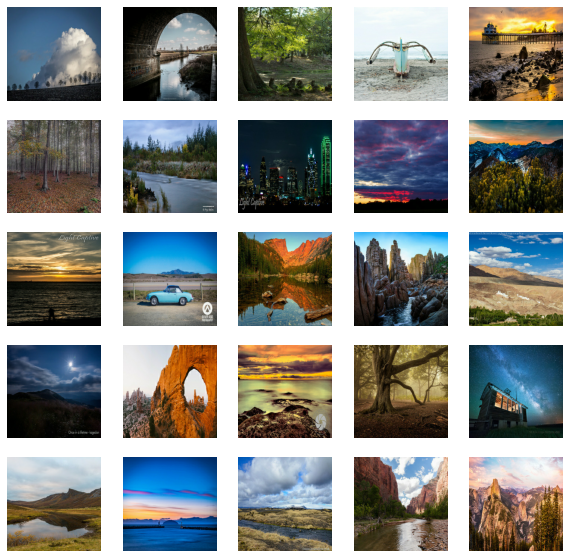

In [10]:
# Visualize some first images from the photo dataset
visualize_images(example_photo)

## Step 3: Building and training Deep Convolutional Generative Adversarial Network (DC GANs)

DC GAN is one of the most used, powerful, and successful types of GAN architecture. It is implemented with help of ConvNets in place of a Multi-layered perceptron. The ConvNets use a convolutional stride and are built without max pooling and layers in this network are not completely connected.   
+ Build the generator that takes a noise vector and outputs a tensor of 256x256x3.   
+ Build the discriminator that takes the tensor of 256x256x3 and outputs a probability that an image is real or fake.   
+ Create two separate loss functions and optimizers for the generator and discriminator.   

#### 3.1 Build the Generator

The generator network takes random Gaussian noise and maps it into input images such that the discriminator cannot tell which images came from the dataset and which images came from the generator.

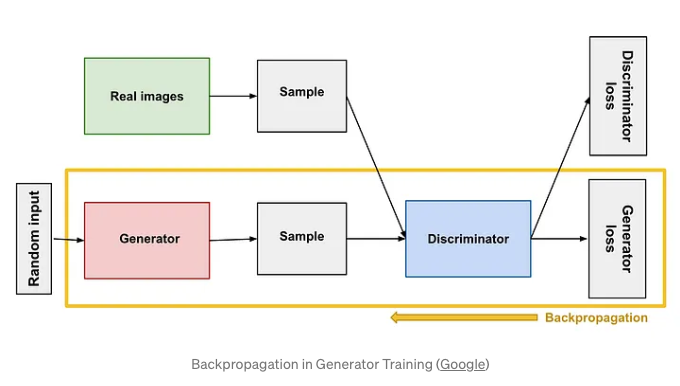

Let’s define our generator model architect:    
The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until we reach the desired image size of 256x256x3. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

+ input_shape=(100,).  
+ Dense is a fully connected layer with a linear activation of size 16x16.  
+ stride to minimize the spread of the layer outputs, used in place of pooling.  
+ Five Conv2DTranspose upsampling layers: input goes from 16x16 to 32x32 to 64x64 to 128x128 to 256x256.  
+ LeakyReLU activation: instead of defining the ReLU activation function as 0 for negative values of inputs(x), we define it as an extremely small linear component of x. 
+ The last Conv2DTranspose upsampling layer is the output layer with tanh activation.  

In [11]:
# create a function to build the generator model
def create_generator():
    model = Sequential(name="Generator")
    
    # Hidden Layer 1: Start with 16 x 16 image
    n_nodes = 16 * 16 * 512 # number of nodes in the first hidden layer
    model.add(Dense(n_nodes, input_shape=(100,), name='Generator-Hidden-Layer-1'))
    model.add(Reshape((16, 16, 512), name='Generator-Hidden-Layer-Reshape-1'))
   
    # Hidden Layer 2: Upsample to 32 x 32
    model.add(Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-2'))
    model.add(LeakyReLU(alpha=0.2))
        
    # Hidden Layer 3: Upsample to 64 x 64
    model.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-3'))
    model.add(LeakyReLU(alpha=0.2))
        
    # Hidden Layer 4: Upsample to 128 x 128
    model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-4'))
    model.add(LeakyReLU(alpha=0.2))
        
    # Hidden Layer 5: Upsample to 256 x 256
    model.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same', name='Generator-Hidden-Layer-5'))
    model.add(LeakyReLU(alpha=0.2))
        
    # Output Layer: we use 3 filters because we have 3 channels for a color image.
    model.add(Conv2DTranspose(3, kernel_size=(3, 3), activation='tanh', strides=(1, 1), padding='same', name='Generator-Output-Layer'))
  
    return model

In [12]:
# Use the noise vector to create an image. The generator is still untrained here!
with strategy.scope():
    generator = create_generator()

# Show model summary
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator-Hidden-Layer-1 (De (None, 131072)            13238272  
_________________________________________________________________
Generator-Hidden-Layer-Resha (None, 16, 16, 512)       0         
_________________________________________________________________
Generator-Hidden-Layer-2 (Co (None, 32, 32, 256)       1179904   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 256)       0         
_________________________________________________________________
Generator-Hidden-Layer-3 (Co (None, 64, 64, 128)       295040    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
Generator-Hidden-Layer-4 (Co (None, 128, 128, 64)      73

In [13]:
!mkdir ../tmp

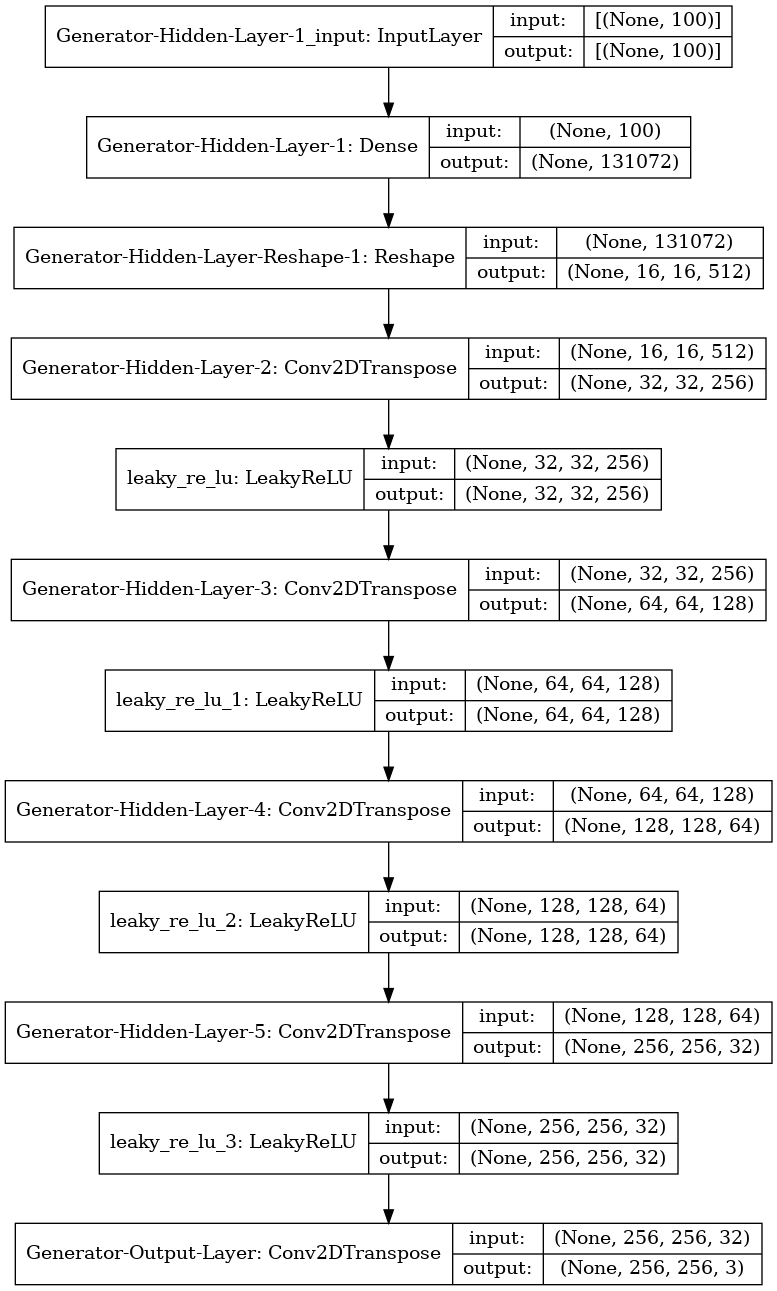

In [14]:
# plot model diagram
plot_model(generator, to_file="../tmp/gen_model.png", show_shapes=True, show_layer_names=True)

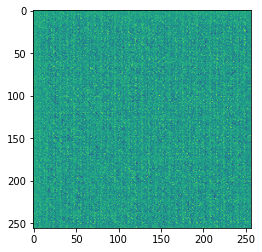

In [15]:
# create vector of random noise to pass through the generator to see what the output is without the network having been trained
noise = tf.random.normal([1, 100])
with strategy.scope():
    generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

### 3.2 Build the Discriminator

The discriminator will be trained to learn to tell the difference between images comes from the dataset and images comes from the generator.

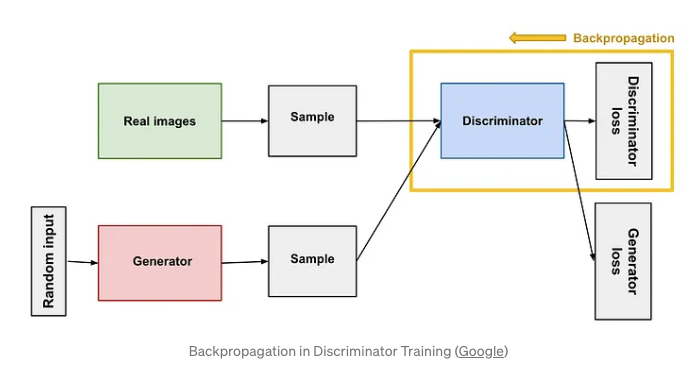

Let’s now define the model architect:

+ input_shape = [256, 256, 3] 
+ Conv2D downsamples using strides=(2x2)
+ LeakyReLU activation
+ Dropout = 0.3: reduces overfitting by reducing the number of neurons.
+ Flatten to convert each input image into a 1D array: if it receives input data X, it computes X.reshape(-1, 1).  
+ Dense: output layer with sigmoid activation to return probabilities, a number between 0 and 1, with 1 representing real and 0 representing fake. We use sigmoid because this is a binary classification problem.  


In [16]:
# create a function to build the discriminator model
def create_discriminator():
    model = Sequential(name="Discriminator") # Model
    
    # Hidden Layer 1
    model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(2, 2), padding='same', input_shape=[256, 256, 3], name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1'))
    
    # Hidden Layer 2
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-2'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2'))
       
    # Hidden Layer 3
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-3'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3'))
      
    # Hidden Layer 4
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-4'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-4'))
  
    # Hidden Layer 5
    model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(2, 2), padding='same', name='Discriminator-Hidden-Layer-5'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-5'))
    
    # Flatten and Output Layers
    model.add(Flatten(name='Discriminator-Flatten-Layer')) # Flatten the shape
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout')) # Randomly drop some connections for better generalization
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer
    
    return model


In [17]:
# Use the noise vector to create an image. The generator is still untrained here!
with strategy.scope():
    discriminator = create_discriminator()

# Show model summary 
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Discriminator-Hidden-Layer-1 (None, 128, 128, 32)      896       
_________________________________________________________________
Discriminator-Hidden-Layer-A (None, 128, 128, 32)      0         
_________________________________________________________________
Discriminator-Hidden-Layer-2 (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
Discriminator-Hidden-Layer-A (None, 64, 64, 64)        0         
_________________________________________________________________
Discriminator-Hidden-Layer-3 (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)     

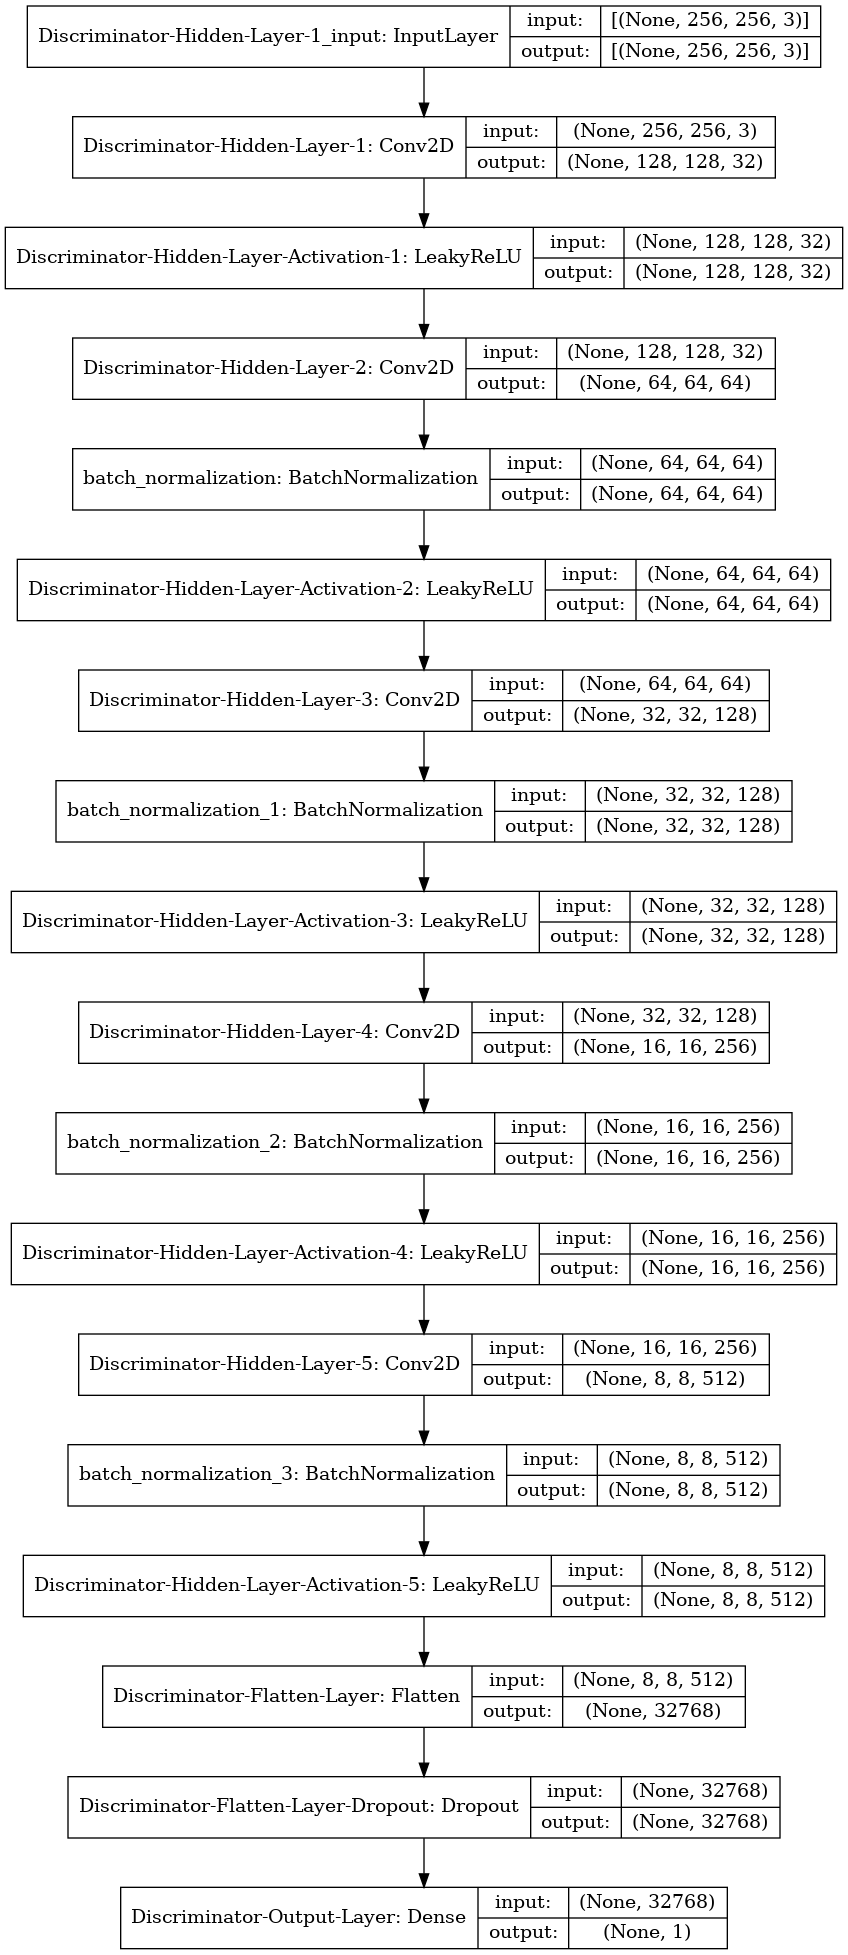

In [19]:
# plot model diagram
plot_model(discriminator, to_file="../tmp/disc_model.png", show_shapes=True, show_layer_names=True)

In [20]:
# Use the discriminator to classify the image above (1 for real and 0 for fake)
with strategy.scope():
    decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49999577]], shape=(1, 1), dtype=float32)


From the result above, we can see that since the decision is not greater than 0.5 which is closer to 0 so the image is fake.

### 3.3 Define Loss Functions & Optimizers

- Create two separate loss functions:  
    + The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.  
    + The discriminator's loss quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s. 
    
- Create two separate optimizers:
    + Both generator and discriminator models use Adam optimizer with learning rate of 0.0002 and beta_1 of 0.5.

In [21]:
# create loss function for the generator
with strategy.scope():
    def generator_loss(fake_output):
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    # create loss function for the discriminator
    def discriminator_loss(real_output, fake_output):
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

In [22]:
# Create two separate optimizers for the generator and discriminator
with strategy.scope():
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

### 3.4 Define the training loop & Visualize Images

The training loop begins with generator receiving a random noise as input. That noise is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

Here, we create:   
    + train_step() is a function that performs one step of training for the generator and discriminator.    
    + generate_and_plot_images() function generates a set of sample images from the generator at regular intervals during training and visualize them.   
    + finally, we will loop that alternates between training the generator and discriminator for a given number of epochs, print running time and mean loss for every 200 epochs.  
    
Using the tf.function() to improve the performance of TensorFlow code.

In [21]:
# Set the hyperparameters to be used for training

EPOCHS = 1000
BATCH_SIZE = 32
noise_dim = 100
shape_dim = [256,256,3]

In [22]:
# create a function trains one step of a DCGAN

@tf.function
def train_step(images):
    
    # Create random noise vector
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # generate images use random noise vector
        generated_images = generator(noise, training=True)

        # use discriminator to evaluate the real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # compute generator loss and discriminator loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Compute gradients
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # Update optimizers
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
    return (gen_loss + disc_loss) * 0.5

In [23]:
@tf.function
def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
    return strategy.reduce(
        tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)

In [24]:
# create plot image function
def plot_image(image):
    # rescale image to [0, 1]
    gen_imgs = 0.5 * image + 0.5
    
    # plot images
    fig, axs = plt.subplots(5, 5, figsize=(10, 10), sharey=True, sharex=True)
    ind = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[ind, :, :, :])
            axs[i, j].axis('off')
            ind += 1

In [25]:
# create a function to generate and plot image
def generate_and_plot_images(model):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) 
    predictions = model.predict(noise)
    plot_image(predictions)

Time for epoch 200 is 0.8124921321868896 sec, total loss is 1.3069030046463013
Time for epoch 400 is 0.8065629005432129 sec, total loss is 1.6615869998931885
Time for epoch 600 is 0.8247485160827637 sec, total loss is 2.7654621601104736
Time for epoch 800 is 0.8130912780761719 sec, total loss is 2.324080228805542
Time for epoch 1000 is 0.8187322616577148 sec, total loss is 1.7169357538223267


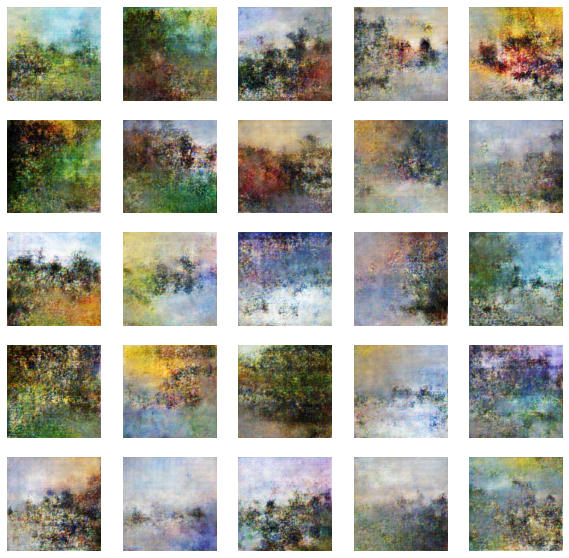

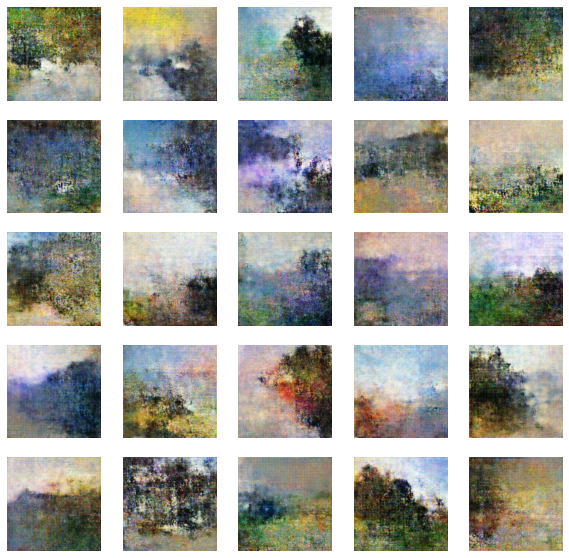

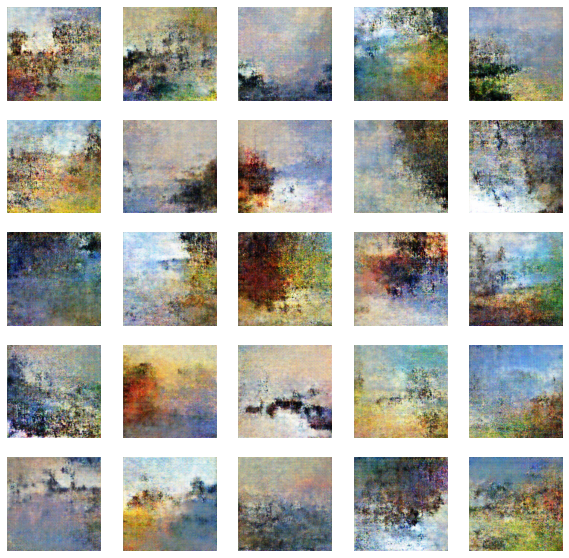

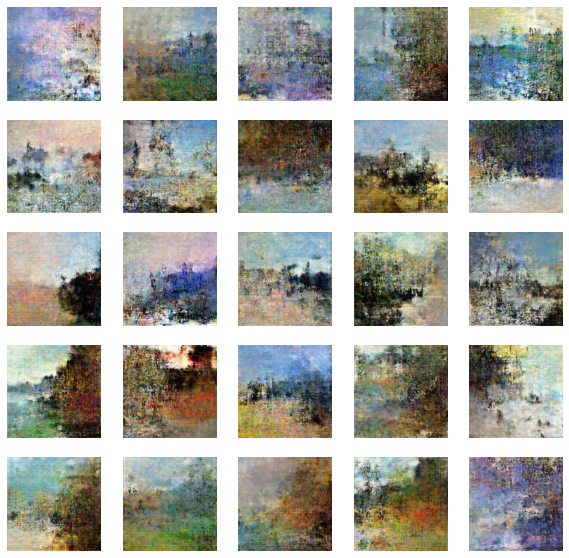

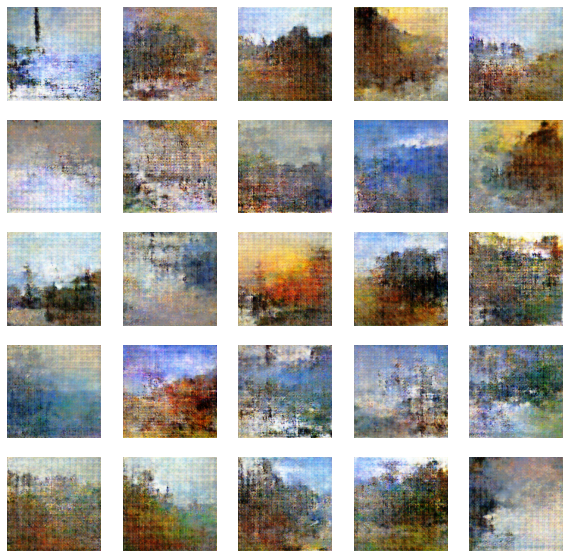

In [26]:
# training loop and visualize images
for epoch in range(EPOCHS):
    start = time.time()
    
    total_loss = 0.0
    num_batches = 0
    
    for image_batch in monet_ds:
        loss = distributed_train_step(image_batch)
        total_loss += tf.reduce_mean(loss)
        num_batches += 1
    mean_loss = total_loss / num_batches
    
    if (epoch+1) % 200 == 0:                                  
        print ('Time for epoch {} is {} sec, total loss is {}'.format(epoch + 1, time.time()-start, mean_loss))
        generate_and_plot_images(generator)

## Step 4: Submit images

In [27]:
# Create new directory
!mkdir ../images

In [31]:
# generate 7000 images
start = time.time()
with strategy.scope():
    for i in range(7000):
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        img = generator.predict(noise)
        img = 0.5 * img + 0.5
        img = (img * 255).astype('uint8')
        img = Image.fromarray(img[0, :, :, :])
        img.save("../images/" + str(i) + ".jpg")
print('Total running time is {} sec'.format(time.time()-start))

Total running time is 3585.0151386260986 sec


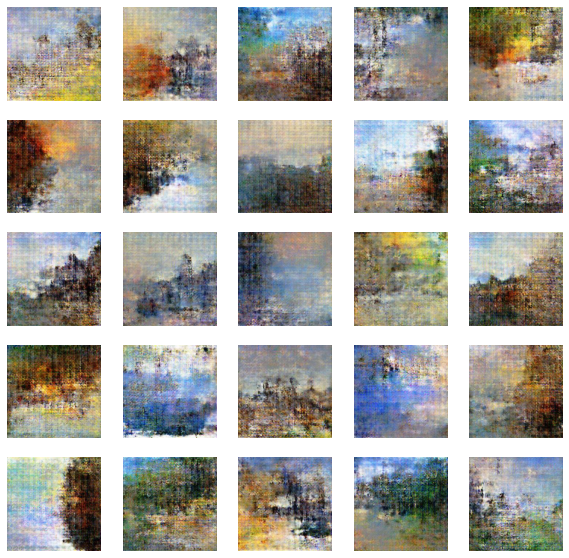

In [32]:
# view some submission DCGAN_images
fig = plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(PIL.Image.open("../images/" + str(i) + ".jpg"))
    plt.axis('off')
plt.show()

In [31]:
# Create a zip file of the images
!zip -q -r images.zip ../images

## Step 5: Conclusion and Takeaways

DCGAN, or Deep Convolutional Generative Adversarial Networks, is a type of generative model that can learn to generate new images by training on a dataset of existing images. DCGANs have shown impressive results in generating realistic images of faces, animals, landscapes, and other objects. Training a DCGAN model requires a significant amount of computational resources and can take a long time, depending on the size of the dataset and the complexity of the model. It is also important to carefully tune the hyperparameters to achieve the best possible results such as:  
    + add more layers and different types of layers and see the effect on the training time and the stability of the training   
    + change the number of filters  
    + adjust the activation functions
    + adjust the learning rate: a high learning rate can cause the model to overshoot the optimal weights, while a low learning rate can result in slow convergence.  
    + add regularization techniques such as dropout, weight decay, or spectral normalization can be used to reduce overfitting and improve the generalization performance of the DCGAN.  
    